In [ ]:
from torchvision import transforms
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset,random_split, DataLoader
import torchvision.transforms.functional as TF
import os
import matplotlib.pyplot as plt
class CellSegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data_paths = self._create_data_paths()
        

    def _create_data_paths(self):
        data_paths = {}
        
        for root in self.root_dir:
            subdirectories = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
            # print(f"Subdirectories in {root}: {subdirectories}")
    
            for subdir in subdirectories:
                subdir_path = os.path.join(root, subdir)
                source_path = os.path.join(subdir_path, "source.jpg")
                mask_all_path = os.path.join(subdir_path, "mask.jpg")
                mask_circular_path = os.path.join(subdir_path, "mask-circular.jpg")
                mask_elongated_path = os.path.join(subdir_path, "mask-elongated.jpg")
                mask_other_path = os.path.join(subdir_path, "mask-other.jpg")
                
                # Check if all files exist
                if (os.path.exists(source_path) and os.path.exists(mask_all_path) and
                    os.path.exists(mask_circular_path) and os.path.exists(mask_elongated_path) and
                    os.path.exists(mask_other_path)):
                    
                    # Create a unique key for each subdirectory path
                    key = f"{os.path.basename(root)}_{subdir}"
                    
                    data_paths[key] = {
                        "image": source_path,
                        "mask_all": mask_all_path,
                        "mask_circular": mask_circular_path,
                        "mask_elongated": mask_elongated_path,
                        "mask_other": mask_other_path,
                    }
                else:
                    print(f"skipped image because something didnt exists:{subdir}")
                    
        print(f"Total paths collected: {len(data_paths)}")
        return data_paths

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        item_key = list(self.data_paths.keys())[idx]
        paths = self.data_paths[item_key]
    
        image = Image.open(paths["image"]).convert("RGB")
        mask_circular = Image.open(paths["mask_circular"]).convert("L")
        mask_elongated = Image.open(paths["mask_elongated"]).convert("L")
        mask_other = Image.open(paths["mask_other"]).convert("L")
    
        if self.transform:
            image = self.transform(image)
    
        # Apply resizing transform to each mask
        mask_circular = self.transform(mask_circular)
        mask_elongated = self.transform(mask_elongated)
        mask_other = self.transform(mask_other)
    
        # Convert masks to numpy arrays
        mask_circular = np.array(mask_circular)
        mask_elongated = np.array(mask_elongated)
        mask_other = np.array(mask_other)
    
        # Initialize the combined mask with background class 0
        combined_mask = np.zeros_like(mask_circular, dtype=np.int64)
    
        # Assign class indices
        combined_mask[mask_circular > 0] = 1  # Class 1 for circular cells
        
        combined_mask[mask_other > 0] = 3      # Class 3 for other cells
        combined_mask[mask_elongated > 0] = 2  # Class 2 for elongated cells
        combined_mask = torch.from_numpy(combined_mask).long()
    
        return image, combined_mask


# Define the root directory and transformations
root_dir = ['erythrocytesIDB3','erythrocytesIDB2']
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Instantiate the dataset
dataset = CellSegmentationDataset(root_dir=root_dir, transform=transform)
print(f"The length of the dataset is:{len(dataset)}")

skipped image because something didnt exists:08erythrocytesIDB3
skipped image because something didnt exists:11erythrocytesIDB3
skipped image because something didnt exists:14erythrocytesIDB2
Total paths collected: 77
The length of the dataset is:77


In [ ]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
from PIL import Image
import os
import random

class CellSegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None, augmentations=None):
        self.root_dir = root_dir if isinstance(root_dir, list) else [root_dir]
        self.transform = transform
        self.augmentations = augmentations or [lambda x: x]  # Include identity transform if no augmentations
        self.data_paths = self._create_data_paths()

    def _create_data_paths(self):
        data_paths = []
        for root in self.root_dir:
            root = os.path.abspath(root)
            subdirectories = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]

            for subdir in subdirectories:
                subdir_path = os.path.join(root, subdir)
                source_path = os.path.join(subdir_path, "source.jpg")
                mask_circular_path = os.path.join(subdir_path, "mask-circular.jpg")
                mask_elongated_path = os.path.join(subdir_path, "mask-elongated.jpg")
                mask_other_path = os.path.join(subdir_path, "mask-other.jpg")

                if all(os.path.exists(p) for p in [source_path, mask_circular_path, mask_elongated_path, mask_other_path]):
                    for aug_index, augmentation in enumerate(self.augmentations):
                        data_paths.append({
                            "image": source_path,
                            "mask_circular": mask_circular_path,
                            "mask_elongated": mask_elongated_path,
                            "mask_other": mask_other_path,
                            "augmentation": augmentation,
                            "aug_index": aug_index,  # Keep track of which augmentation is applied
                            "subdir": subdir
                        })
                else:
                    print(f"Skipped {subdir} due to missing files.")
        print(f"Total paths collected: {len(data_paths)}")
        return data_paths

    def __len__(self):
        return len(self.data_paths)

    def _combine_masks(self, mask_circular, mask_elongated, mask_other):
        combined_mask = torch.zeros_like(mask_circular, dtype=torch.long)
        combined_mask[mask_circular > 0] = 1
        combined_mask[mask_elongated > 0] = 2
        combined_mask[mask_other > 0] = 3
        return combined_mask

    def __getitem__(self, idx):
        paths = self.data_paths[idx]
        image = Image.open(paths["image"]).convert("RGB")
        mask_circular = Image.open(paths["mask_circular"]).convert("L")
        mask_elongated = Image.open(paths["mask_elongated"]).convert("L")
        mask_other = Image.open(paths["mask_other"]).convert("L")
        # Apply transforms
        if self.transform:
            image = self.transform(image)
            mask_circular = self.transform(mask_circular)
            mask_elongated = self.transform(mask_elongated)
            mask_other = self.transform(mask_other)
        else:
            image = TF.to_tensor(image)
            mask_circular = TF.to_tensor(mask_circular)
            mask_elongated = TF.to_tensor(mask_elongated)
            mask_other = TF.to_tensor(mask_other)
        # Apply the specific augmentation
        augmentation = paths["augmentation"]
        image = augmentation(image)
        mask_circular = augmentation(mask_circular)
        mask_elongated = augmentation(mask_elongated)
        mask_other = augmentation(mask_other)

        

        # Combine masks
        mask_circular = mask_circular.squeeze(0)
        mask_elongated = mask_elongated.squeeze(0)
        mask_other = mask_other.squeeze(0)
        combined_mask = self._combine_masks(mask_circular, mask_elongated, mask_other)

        return image, combined_mask

from torchvision import transforms

# Define the specific augmentations you want to apply
augmentations = [
    lambda x: x,  
    lambda x: TF.rotate(x, 90),
    lambda x: TF.rotate(x, -90),
    lambda x: TF.hflip(x),
    lambda x: TF.vflip(x),
]

# Define transformations for the images and masks
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Instantiate the dataset
dataset = CellSegmentationDataset(
    root_dir=['erythrocytesIDB3', 'erythrocytesIDB2'],
    transform=transform,
    augmentations=augmentations
)

print(f"The length of the dataset is: {len(dataset)}")


Skipped 11erythrocytesIDB3 due to missing files.
Total paths collected: 395
The length of the dataset is: 395


In [8]:
len(['10erythrocytesIDB3', '04erythrocytesIDB3', '12erythrocytesIDB3', '09erythrocytesIDB3', '03erythrocytesIDB3', '08erythrocytesIDB3', '28erythrocytesIDB3', '05erythrocytesIDB3', '07erythrocytesIDB3', '17erythrocytesIDB3', '18erythrocytesIDB3', '14erythrocytesIDB3', '26erythrocytesIDB3', '02erythrocytesIDB3', '01erythrocytesIDB3', '19erythrocytesIDB3', '27erythrocytesIDB3', '13erythrocytesIDB3', '22erythrocytesIDB3', '24erythrocytesIDB3', '25erythrocytesIDB3', '11erythrocytesIDB3', '29erythrocytesIDB3', '23erythrocytesIDB3', '30erythrocytesIDB3', '21erythrocytesIDB3', '16erythrocytesIDB3', '06erythrocytesIDB3', '15erythrocytesIDB3', '20erythrocytesIDB3'])

30

In [9]:
len(['42erythrocytesIDB2', '11erythrocytesIDB2', '05erythrocytesIDB2', '26erythrocytesIDB2', '40erythrocytesIDB2', '07erythrocytesIDB2', '03erythrocytesIDB2', '13erythrocytesIDB2', '31erythrocytesIDB2', '30erythrocytesIDB2', '06erythrocytesIDB2', '37erythrocytesIDB2', '33erythrocytesIDB2', '38erythrocytesIDB2', '24erythrocytesIDB2', '35erythrocytesIDB2', '50erythrocytesIDB2', '20erythrocytesIDB2', '04erythrocytesIDB2', '34erythrocytesIDB2', '36erythrocytesIDB2', '09erythrocytesIDB2', '47erythrocytesIDB2', '46erythrocytesIDB2', '16erythrocytesIDB2', '01erythrocytesIDB2', '41erythrocytesIDB2', '23erythrocytesIDB2', '02erythrocytesIDB2', '22erythrocytesIDB2', '43erythrocytesIDB2', '17erythrocytesIDB2', '48erythrocytesIDB2', '28erythrocytesIDB2', '08erythrocytesIDB2', '32erythrocytesIDB2', '12erythrocytesIDB2', '21erythrocytesIDB2', '45erythrocytesIDB2', '14erythrocytesIDB2', '44erythrocytesIDB2', '10erythrocytesIDB2', '19erythrocytesIDB2', '29erythrocytesIDB2', '27erythrocytesIDB2', '15erythrocytesIDB2', '39erythrocytesIDB2', '18erythrocytesIDB2', '49erythrocytesIDB2', '25erythrocytesIDB2'])

50

In [44]:
index = 0
print(f"The length of an example is:{len(dataset.__getitem__(index))}")
print(f"The structure of an example is:{dataset.__getitem__(index)[0]}")
print(f"The mask of an example is:{dataset.__getitem__(index)[1]}")

The length of an example is:2
The structure of an example is:tensor([[[0.4471, 0.4392, 0.4235,  ..., 0.6431, 0.6471, 0.6471],
         [0.4471, 0.4392, 0.4235,  ..., 0.6431, 0.6471, 0.6471],
         [0.4431, 0.4353, 0.4235,  ..., 0.6471, 0.6431, 0.6392],
         ...,
         [0.5843, 0.5843, 0.5882,  ..., 0.6039, 0.6039, 0.6039],
         [0.5765, 0.5804, 0.5843,  ..., 0.6039, 0.6039, 0.6039],
         [0.5765, 0.5804, 0.5843,  ..., 0.6039, 0.6039, 0.6039]],

        [[0.3843, 0.3765, 0.3647,  ..., 0.5882, 0.5922, 0.5922],
         [0.3843, 0.3765, 0.3647,  ..., 0.5882, 0.5882, 0.5882],
         [0.3804, 0.3725, 0.3608,  ..., 0.5843, 0.5804, 0.5765],
         ...,
         [0.5255, 0.5255, 0.5294,  ..., 0.5490, 0.5490, 0.5490],
         [0.5216, 0.5216, 0.5255,  ..., 0.5490, 0.5490, 0.5490],
         [0.5216, 0.5216, 0.5255,  ..., 0.5490, 0.5490, 0.5490]],

        [[0.4980, 0.4941, 0.4902,  ..., 0.5765, 0.5804, 0.5804],
         [0.4980, 0.4941, 0.4902,  ..., 0.5765, 0.5804, 0.5804

In [ ]:
from torch.utils.data import DataLoader
# Define dataset sizes for train, validation, and test (e.g., 70%, 15%, 15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Define batch size and number of workers
batch_size = 4
num_workers = 2

# Initialize DataLoaders for each subset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Checking a sample from train_loader
image, masks = train_dataset[0]
print("Image shape:", image.shape)
print("All mask shape:", masks.shape)


Image shape: torch.Size([3, 512, 512])
All mask shape: torch.Size([512, 512])


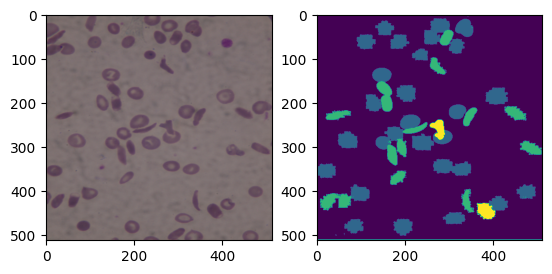

In [49]:

images,labels = next(iter(test_loader))
plt.subplot(1,2,1)
plt.imshow(images[0].numpy().transpose((1, 2, 0)))
plt.subplot(1,2,2)
plt.imshow(labels[0])

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        
        # Define layers for the encoder
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Define layers for the decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Final output layer
        self.conv_out = nn.Conv2d(64, num_classes, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return self.conv_out(dec1)

In [51]:
from torchsummary import summary
modelsa = UNet(num_classes=4)
modelsa.to('cuda') 
summary(modelsa, input_size=(3, 512, 512))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
            Conv2d-5        [-1, 128, 256, 256]          73,856
              ReLU-6        [-1, 128, 256, 256]               0
            Conv2d-7        [-1, 128, 256, 256]         147,584
              ReLU-8        [-1, 128, 256, 256]               0
            Conv2d-9        [-1, 256, 128, 128]         295,168
             ReLU-10        [-1, 256, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         590,080
             ReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13          [-1, 512, 64, 64]       1,180,160
             ReLU-14          [-1, 512,

In [52]:
print([(i, torch.cuda.get_device_properties(i)) for i in range(torch.cuda.device_count())])
print(torch.version.cuda)  # Check CUDA version
print(torch.backends.cudnn.version())  # Check cuDNN version

[(0, _CudaDeviceProperties(name='NVIDIA A100-SXM4-40GB', major=8, minor=0, total_memory=40337MB, multi_processor_count=108)), (1, _CudaDeviceProperties(name='NVIDIA A100-SXM4-40GB', major=8, minor=0, total_memory=40337MB, multi_processor_count=108)), (2, _CudaDeviceProperties(name='NVIDIA A100-SXM4-40GB', major=8, minor=0, total_memory=40337MB, multi_processor_count=108)), (3, _CudaDeviceProperties(name='NVIDIA A100-SXM4-40GB', major=8, minor=0, total_memory=40337MB, multi_processor_count=108)), (4, _CudaDeviceProperties(name='NVIDIA DGX Display', major=7, minor=5, total_memory=3903MB, multi_processor_count=14))]
12.1
8902


In [53]:
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

# Assuming train_loader, val_loader, and test_loader are defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
# Define the model and move it to GPU(s)
model = UNet(num_classes=4)
model = torch.nn.DataParallel(model, device_ids=[ 0,1, 2,3])
# device = torch.device("cpu")
if load_model:
    # Load the model
    model.load_state_dict(torch.load('cell_segmentation_model_30_epoch.pth'))



model = model.to(device)
def hybrid_loss(pred, target, beta=1.0):
    ce_loss = torch.nn.functional.cross_entropy(pred, target)
    dice = dice_loss(torch.sigmoid(pred), target)
    return ce_loss + beta * dice


def dice_loss(pred, target, smooth=1e-6):
    # pred: [batch, channels, height, width], pred should be softmax probabilities
    # target: [batch, height, width], target should be indices of classes (0 to C-1)
    
    pred = torch.softmax(pred, dim=1)  # Apply softmax to obtain probabilities
    C = pred.shape[1]  # Number of classes

    dice = 0
    for c in range(C):
        pred_c = pred[:, c, :, :]
        target_c = (target == c).float()  # Create a mask for class c

        intersection = (pred_c * target_c).sum((1, 2))  # Sum over each image separately
        union = pred_c.sum((1, 2)) + target_c.sum((1, 2))

        dice_c = (2. * intersection + smooth) / (union + smooth)
        dice += dice_c.mean()  # Average over all images in the batch

    return 1 - dice / C  # Average over all classes



# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
train_losses, val_losses = [], []
# Training and validation

In [54]:

num_epochs = 100


for epoch in range(num_epochs):
    # Training
    model.train()
    running_train_loss = 0.0
    for images, target_masks in train_loader:
        images = images.to(device)
        target_masks = target_masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = dice_loss(outputs, target_masks)
        
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    train_losses.append(running_train_loss / len(train_loader))

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            target_masks = masks.to(device).long()
            outputs = model(images)
            loss = dice_loss(outputs, target_masks)
    
            running_val_loss += loss.item()
    val_losses.append(running_val_loss / len(val_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")



Epoch [1/100], Train Loss: 0.7824, Val Loss: 0.7444
Epoch [2/100], Train Loss: 0.7081, Val Loss: 0.6327
Epoch [3/100], Train Loss: 0.5585, Val Loss: 0.5020
Epoch [4/100], Train Loss: 0.4999, Val Loss: 0.4975
Epoch [5/100], Train Loss: 0.4970, Val Loss: 0.4940
Epoch [6/100], Train Loss: 0.4937, Val Loss: 0.4922
Epoch [7/100], Train Loss: 0.4925, Val Loss: 0.4901
Epoch [8/100], Train Loss: 0.4906, Val Loss: 0.4913
Epoch [9/100], Train Loss: 0.4896, Val Loss: 0.4902
Epoch [10/100], Train Loss: 0.4898, Val Loss: 0.4970
Epoch [11/100], Train Loss: 0.4895, Val Loss: 0.4872
Epoch [12/100], Train Loss: 0.4867, Val Loss: 0.4881
Epoch [13/100], Train Loss: 0.4859, Val Loss: 0.4858
Epoch [14/100], Train Loss: 0.4847, Val Loss: 0.4931
Epoch [15/100], Train Loss: 0.4856, Val Loss: 0.4841
Epoch [16/100], Train Loss: 0.4763, Val Loss: 0.4852
Epoch [17/100], Train Loss: 0.4594, Val Loss: 0.3981
Epoch [18/100], Train Loss: 0.3817, Val Loss: 0.3806
Epoch [19/100], Train Loss: 0.3578, Val Loss: 0.3676
Ep

In [55]:
print(target_masks.min().item(), target_masks.max().item())
print(images.min().item(),images.max().item())


0 3
0.20392157137393951 0.7215686440467834


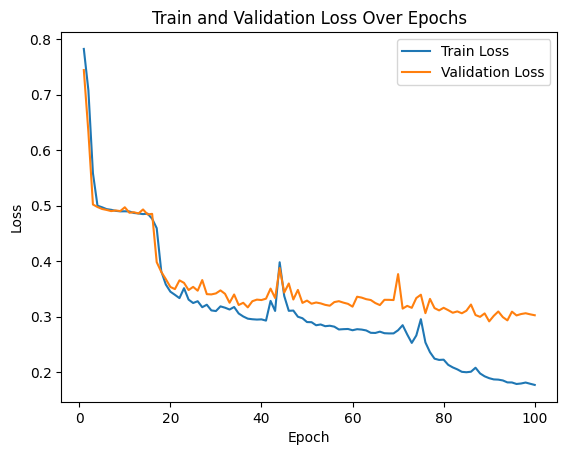

In [56]:

# Plot train and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train and Validation Loss Over Epochs")
plt.show()

In [64]:
overwrite_model = 0
name_of_model= 'cell_dice_loss_augmented_data_100_epoch.pth'
if overwrite_model:
    
    torch.save(model.state_dict(), f'{name_of_model}')
    with open(f"loss_and_val_for model:{name_of_model[:-3]+'txt'}",'w') as f:
        f.write(f"Train_loss:{train_losses}\n")
        f.write(f"Val_loss:{val_losses}\n")


In [ ]:
with open('loss_and_val_for model:cell_hybridloss_100_epoch.txt','r') as f:
    print(f.readline())

Output min value: 0
Output max value: 3


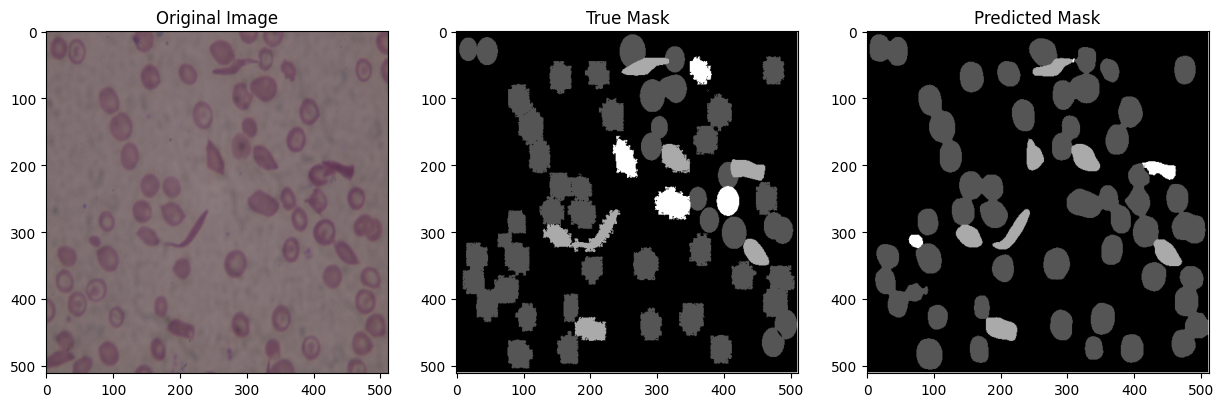

In [57]:
model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        target_masks = masks.to(device)
        
        # Get the model prediction
        outputs = model(images)
        predicted_masks = torch.argmax(outputs, dim=1)

        # Verify output range and distribution
        print("Output min value:", predicted_masks.min().item())
        print("Output max value:", predicted_masks.max().item())

        # Select a random sample from the batch
        idx = np.random.randint(0, images.size(0))
        img = images[idx].cpu().permute(1, 2, 0).numpy()
        true_mask = target_masks[idx].cpu().numpy()
        pred_mask = predicted_masks[idx].cpu().numpy()

        # Plot the image, true mask, and predicted mask
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(img)
        axes[0].set_title("Original Image")
        axes[1].imshow(true_mask, cmap="gray")
        axes[1].set_title("True Mask")
        axes[2].imshow(pred_mask, cmap="gray")
        axes[2].set_title("Predicted Mask")
        plt.show()
        break

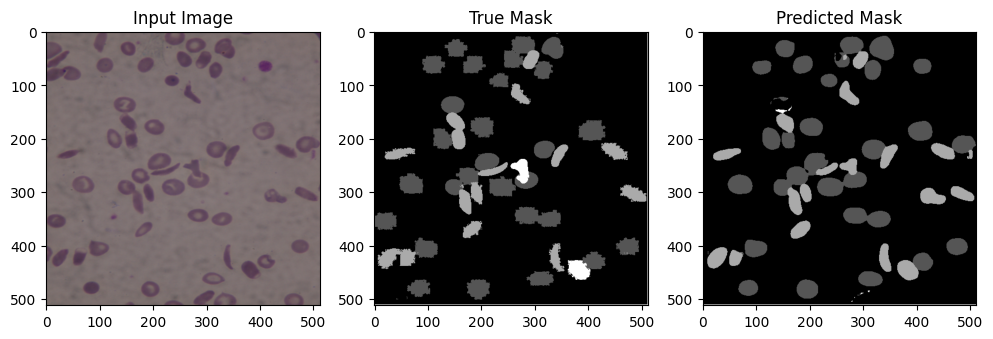

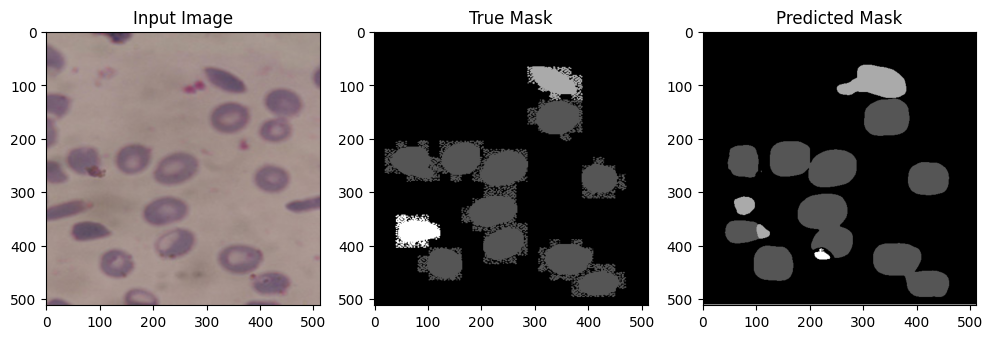

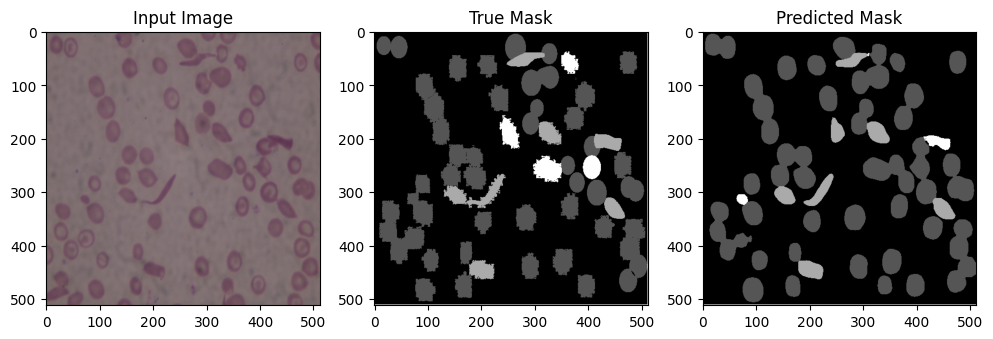

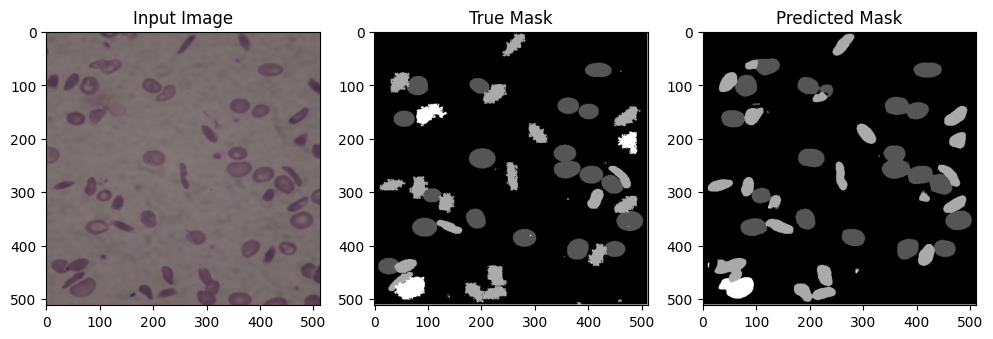

In [58]:
# Get a batch of images and masks from the test loader
images, true_masks = next(iter(test_loader))
images = images.to(device)
true_masks = true_masks.to(device)

# Get model predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    probabilities = F.softmax(outputs, dim=1)  # Convert logits to probabilities
    preds = torch.argmax(probabilities, dim=1)

# Visualize the results
import matplotlib.pyplot as plt

for i in range(len(images)):
    image = images[i].cpu().permute(1, 2, 0)
    true_mask = true_masks[i].cpu()
    pred_mask = preds[i].cpu()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Input Image')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.show()
    

Predicted Elongated Cells: 19
Actual Elongated Cells (counted by opencv): 13


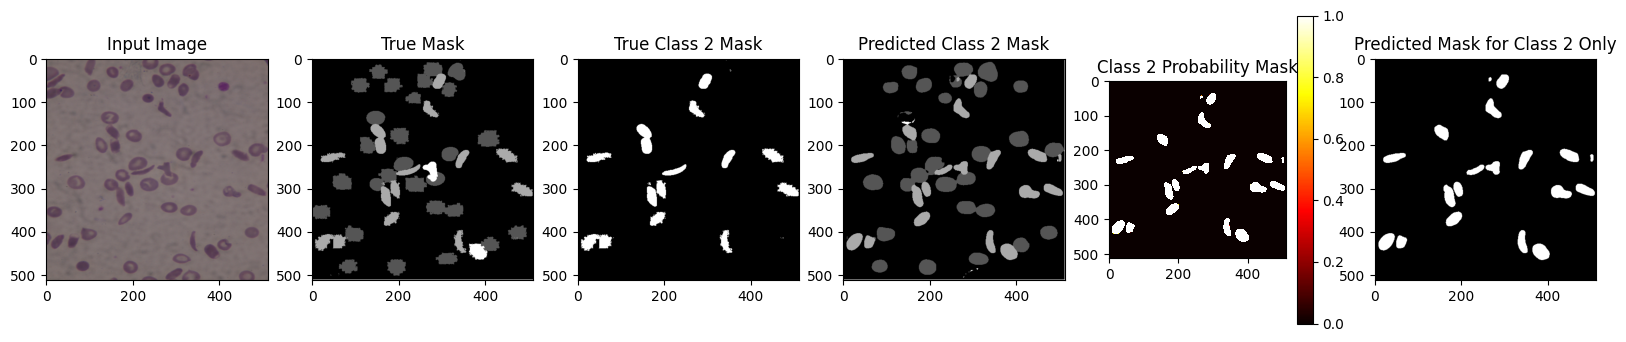

Predicted Elongated Cells: 3
Actual Elongated Cells (counted by opencv): 1


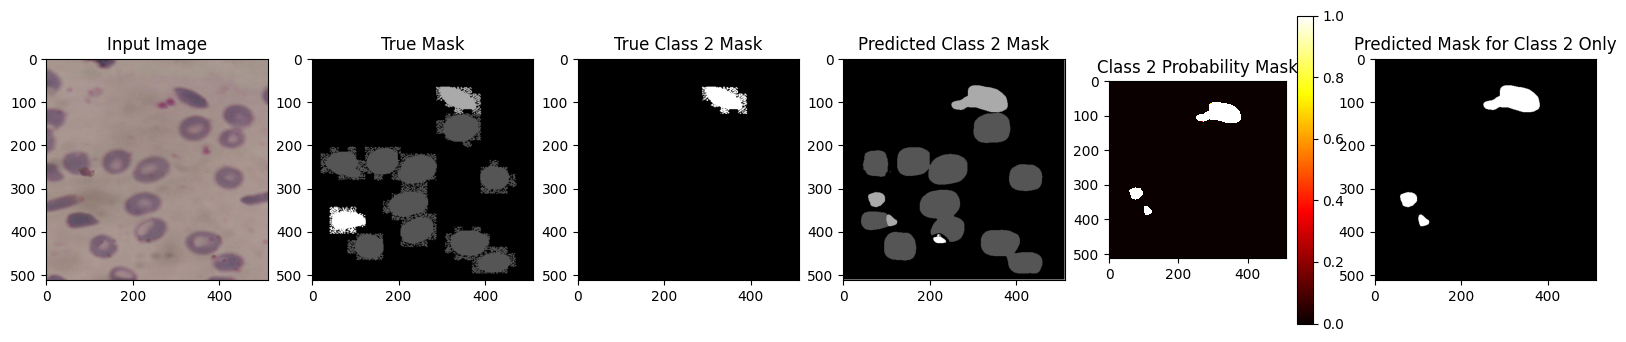

Predicted Elongated Cells: 7
Actual Elongated Cells (counted by opencv): 7


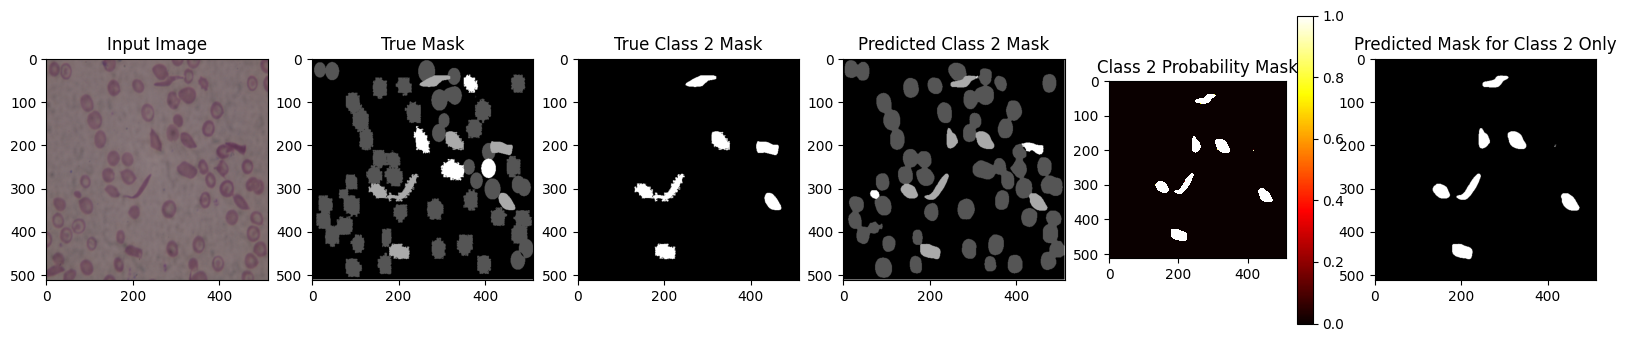

Predicted Elongated Cells: 20
Actual Elongated Cells (counted by opencv): 16


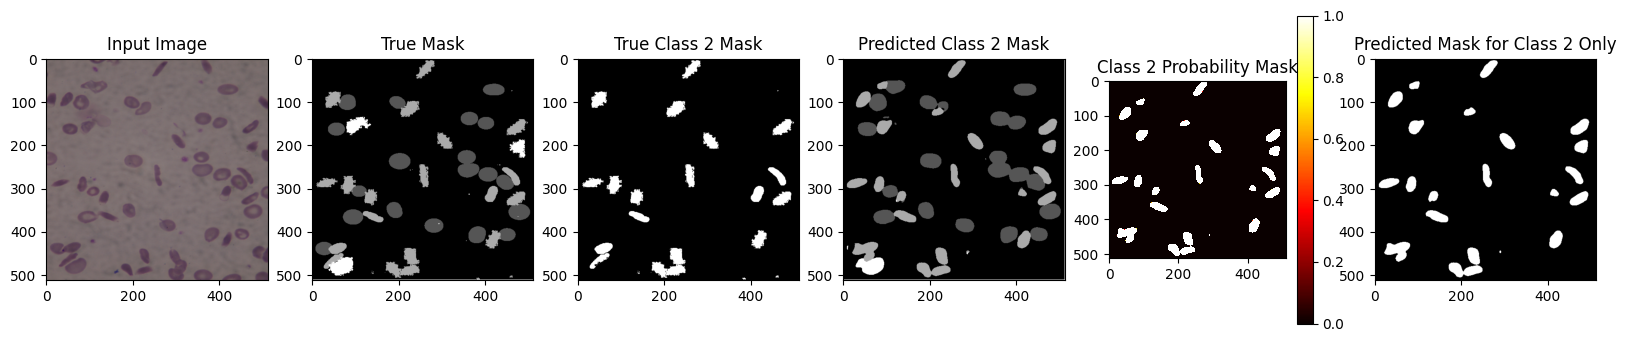

In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def count_class_2_cells(pred_mask, class_label=2, min_size=50):
    pred_mask = np.array(pred_mask)
    binary_mask = (pred_mask == class_label).astype(np.uint8)
    
    # Apply a morphological opening to remove small objects
    kernel = np.ones((3,3), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)

    # Use connected components to find all cells
    num_labels, labels_im = cv2.connectedComponents(binary_mask)

    # Apply size filtering
    cell_count = 0
    for label in range(1, num_labels):  # Start from 1 to ignore the background
        if np.sum(labels_im == label) >= min_size:
            cell_count += 1

    return cell_count

model.eval()
with torch.no_grad():
    outputs = model(images)
    probabilities = F.softmax(outputs, dim=1)  # Convert logits to probabilities

# Assuming class 2 is the class of interest
class_index = 2

# Visualize the results
for i in range(len(images)):
    image = images[i].cpu().permute(1, 2, 0)  # Convert image to [H, W, C] format
    true_mask = true_masks[i].cpu()
    pred_mask = torch.argmax(probabilities[i], dim=0).cpu()  # Get the argmax for the i-th image in the batch
    class_prob_mask = probabilities[i, class_index].cpu()  # Get the probability map for class 2
    class_2_mask = (pred_mask == class_index).cpu()  # Binary mask for predicted class 2
    class_2_count = count_class_2_cells(pred_mask)
    actual_count = count_class_2_cells(true_mask)
    print(f"Predicted Elongated Cells: {class_2_count}")
    print(f"Actual Elongated Cells (counted by opencv): {actual_count}")
    true_class_2_mask = (true_mask == class_index).cpu()  # Binary mask for true class 2

    plt.figure(figsize=(20, 4))  # Adjust figure size to accommodate six subplots
    
    plt.subplot(1, 6, 1)
    plt.imshow(image)
    plt.title('Input Image')

    plt.subplot(1, 6, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Mask')

    plt.subplot(1, 6, 3)
    plt.imshow(true_class_2_mask, cmap='gray')
    plt.title('True Class 2 Mask')

    plt.subplot(1, 6, 4)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Class 2 Mask')

    plt.subplot(1, 6, 5)
    plt.imshow(class_prob_mask, cmap='hot', interpolation='nearest')
    plt.title('Class 2 Probability Mask')
    plt.colorbar()  # Color bar to indicate the scale of probabilities

    plt.subplot(1, 6, 6)
    plt.imshow(class_2_mask, cmap='gray')
    plt.title('Predicted Mask for Class 2 Only')

    plt.savefig("Model_so_far")
    plt.show()


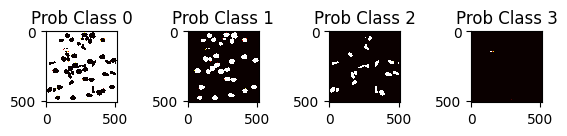

In [60]:
fig,ax = plt.subplots(1,4)
for class_index in range(4):
    ax[class_index].imshow(probabilities[0, class_index].cpu(), cmap='hot', interpolation='nearest')
    ax[class_index].set_title(f'Prob Class {class_index}')
plt.subplots_adjust(wspace=1)
plt.show()


In [61]:
def calculate_iou(preds, labels, smooth=1e-6):
    # Flatten label and prediction tensors
    preds = preds.view(-1)
    labels = labels.view(-1)
    
    # True positives, false positives, and false negatives
    intersection = (preds & labels).float().sum()  # Intersection points
    union = (preds | labels).float().sum()         # Union points
    
    iou = (intersection + smooth) / (union + smooth)  # IoU
    
    return iou

def calculate_dice(preds, labels, smooth=1e-6):
    preds = preds.view(-1)
    labels = labels.view(-1)
    
    intersection = (preds & labels).float().sum()
    dice = (2. * intersection + smooth) / (preds.sum() + labels.sum() + smooth)
    
    return dice

def calculate_precision_recall_f1(preds, labels):
    preds = preds.view(-1)
    labels = labels.view(-1)
    
    tp = (preds & labels).sum().float()
    tn = ((1 - preds) & (1 - labels)).sum().float()
    fp = (preds & (1 - labels)).sum().float()
    fn = ((1 - preds) & labels).sum().float()
    
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    
    return precision.item(), recall.item(), f1.item()


In [62]:
from sklearn.metrics import roc_curve, auc
import numpy as np

def calculate_roc_auc(probs, true_masks, num_classes=4):
    # One-hot encode the true masks if they are not already
    true_one_hot = torch.nn.functional.one_hot(true_masks, num_classes=num_classes).permute(0, 3, 1, 2).contiguous()
    fig, ax = plt.subplots(1, num_classes, figsize=(20, 5))
    roc_aucs = []
    for cls in range(num_classes):
        # Flatten the output and label tensors to shape [batch_size * height * width]
        true_binary = true_one_hot[:, cls].flatten().cpu().numpy()
        probs_cls = probs[:, cls].flatten().cpu().numpy()

        # Calculate ROC curve and ROC area for each class
        fpr, tpr, _ = roc_curve(true_binary, probs_cls)
        roc_auc = auc(fpr, tpr)
        roc_aucs.append(roc_auc)

        # Optionally plot the ROC curves
        
        # Plot the ROC curve for each class
        ax[cls].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        ax[cls].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax[cls].set_xlim([0.0, 1.0])
        ax[cls].set_ylim([0.0, 1.05])
        ax[cls].set_xlabel('False Positive Rate')
        ax[cls].set_ylabel('True Positive Rate')
        ax[cls].set_title(f'ROC for class {cls}')
        ax[cls].legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

    return roc_aucs


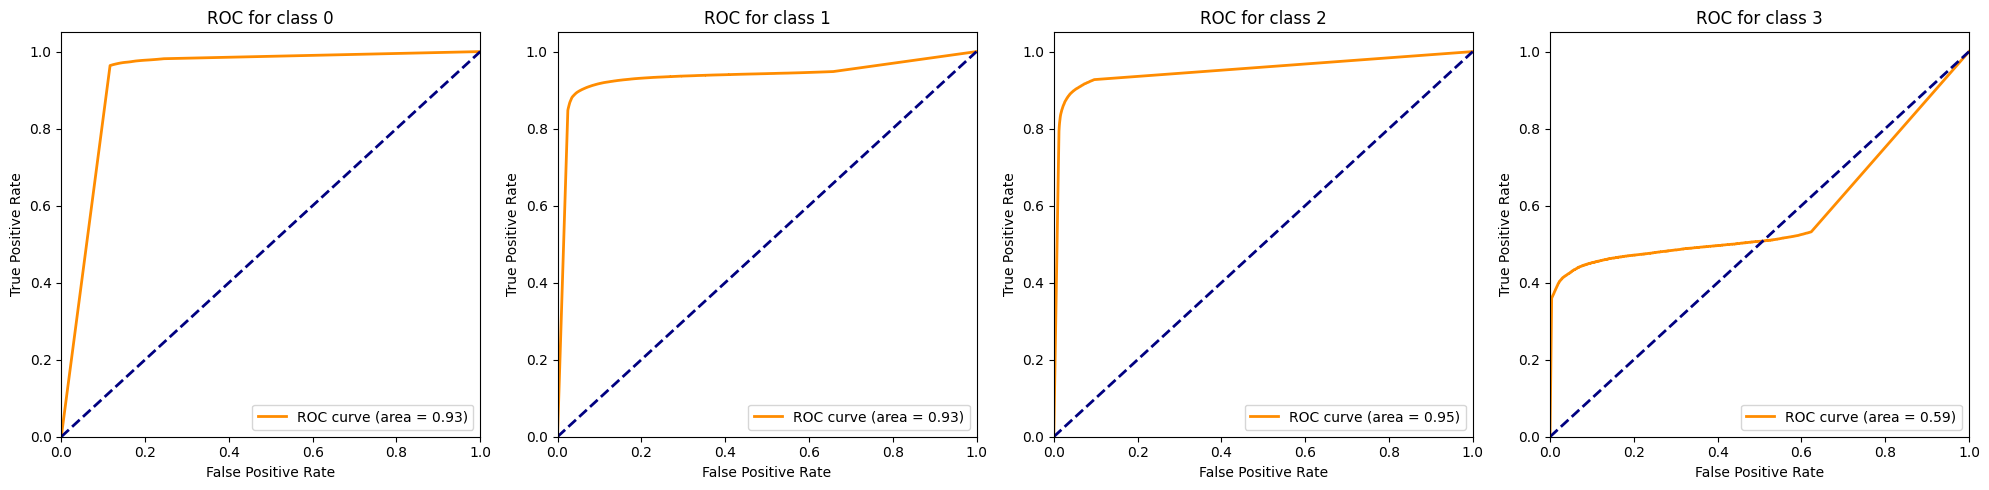

Mean ROC AUC: 0.8506
Mean IoU: 0.6969
Mean Dice: 0.8213
Mean Precision: 0.6803
Mean Recall: 0.6659
Mean F1: 0.6730


In [63]:
from torchvision.transforms.functional import to_pil_image

model.eval()
iou_scores = []
dice_scores = []
precisions = []
recalls = []
f1_scores = []
roc_auc_scores = []
with torch.no_grad():
    for images, true_masks in test_loader:
        images = images.to(device)
        true_masks = true_masks.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        iou_scores.append(calculate_iou(preds, true_masks))
        dice_scores.append(calculate_dice(preds, true_masks))
        roc_auc_scores.extend(calculate_roc_auc(probs, true_masks, 4))
        precision, recall, f1 = calculate_precision_recall_f1(preds, true_masks)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        break

# Calculate mean of each metric
mean_iou = torch.mean(torch.tensor(iou_scores))
mean_dice = torch.mean(torch.tensor(dice_scores))
mean_precision = torch.mean(torch.tensor(precisions))
mean_recall = torch.mean(torch.tensor(recalls))
mean_f1 = torch.mean(torch.tensor(f1_scores))
mean_roc_auc = np.mean(roc_auc_scores)
print(f'Mean ROC AUC: {mean_roc_auc:.4f}')
print(f'Mean IoU: {mean_iou:.4f}')
print(f'Mean Dice: {mean_dice:.4f}')
print(f'Mean Precision: {mean_precision:.4f}')
print(f'Mean Recall: {mean_recall:.4f}')
print(f'Mean F1: {mean_f1:.4f}')


(2160, 3840, 3)


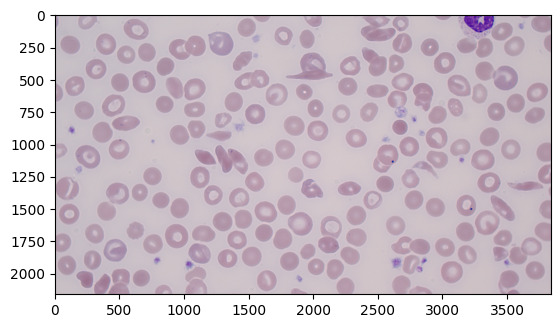

In [141]:
manu_image = plt.imread(image_paths)
print(manu_image.shape)
manu_image = torch.from_numpy(manu_image).permute(2, 0, 1).int()
plt.imshow(manu_image.permute(1, 2, 0))


In [ ]:
manu_image = manu_image.float()
manu_image.to('cpu')
model = model.to('cpu')
out = model(manu_image.permute(0,1,2).unsqueeze(0))
probs = F.softmax(out, dim=1)
preds = torch.argmax(probs, dim=1)

In [153]:
manu_image.permute(0,1,2).unsqueeze(0).shape

torch.Size([1, 3, 2160, 3840])

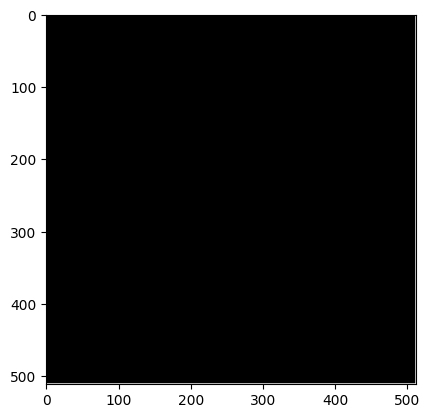

In [133]:
plt.imshow(np.array(torch.squeeze(preds).to('cpu')),cmap='gray')

In [ ]:
plt.subplot(1,2,1)
plt.imshow(manu_image[0].cpu().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(preds.cpu().transpose((1, 2, 0)),cmap='gray')